# Read PDF

In [6]:
from pdf2image import convert_from_path
import pytesseract
from PIL import Image
import os
from tqdm import tqdm

def ocr_pdf_to_txt_per_page(pdf_path, output_dir="ocr_pages", dpi=300):
    """
    Converts a PDF to individual text files (one per page) using OCR.
    
    Args:
        pdf_path (str): Path to the input PDF.
        output_dir (str): Directory where output .txt files will be saved.
        dpi (int): Resolution for converting PDF pages to images.
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Convert PDF to images
    images = convert_from_path(pdf_path, dpi=dpi)

    # OCR each image and save as .txt
    for i, img in enumerate(tqdm(images, desc="OCR Processing"), start=1):
        text = pytesseract.image_to_string(img)
        output_path = os.path.join(output_dir, f"page_{i}.txt")
        with open(output_path, "w", encoding="utf-8") as f:
            f.write(text)

    print(f"\n✅ Saved {len(images)} text files to: {output_dir}")



In [4]:
ocr_pdf_to_txt_per_page("/Users/othmanbensouda/Desktop/LASC/debt_collection_project/documents/23CHLC18998_94523059.pdf")


OCR Processing: 100%|██████████| 18/18 [00:37<00:00,  2.11s/it]


✅ Saved 18 text files to: ocr_pages


# Vectorize and send to pinecone

In [13]:
import os
from dotenv import load_dotenv
from tqdm import tqdm
from openai import OpenAI
from pinecone import Pinecone
from langchain_pinecone import PineconeVectorStore
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings



# === Load .env ===
load_dotenv()

# === Set up OpenAI + Pinecone clients ===
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
pc = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))
index = pc.Index("lasc")

embedding = OpenAIEmbeddings(model="text-embedding-3-small")
vector_store = PineconeVectorStore(index=index, embedding=embedding)


# === Load OCR .txt files ===
output_dir = "ocr_pages"
docs = []
for filename in tqdm(sorted(os.listdir(output_dir)), desc="Loading OCR"):
    if filename.endswith(".txt"):
        with open(os.path.join(output_dir, filename), "r", encoding="utf-8") as f:
            content = f.read().strip()
            if content:
                docs.append(Document(page_content=content, metadata={"source": filename}))

# === Split documents ===
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = splitter.split_documents(docs)

# === Upload to Pinecone ===
vector_store.add_documents(all_splits)
print(f"✅ Indexed {len(all_splits)} chunks from {len(docs)} OCR pages.")



Loading OCR: 100%|██████████| 18/18 [00:00<00:00, 2693.36it/s]


✅ Indexed 59 chunks from 17 OCR pages.


# Query 

In [2]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone
from dotenv import load_dotenv
import os

# Load env vars
load_dotenv()

# Clients
llm = ChatOpenAI(model="gpt-4", temperature=0)  # or "gpt-3.5-turbo"
embedding = OpenAIEmbeddings(model="text-embedding-3-small")
pc = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))
index = pc.Index("lasc")
vectorstore = PineconeVectorStore(index=index, embedding=embedding)


/Users/othmanbensouda/Desktop/LASC/debt_collection_project/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from langchain.chains import RetrievalQA

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=vectorstore.as_retriever(),
    return_source_documents=True
)


In [16]:
query = "Is the plaintiff a debt buyer?"
response = qa_chain.invoke({"query": query})

print("Answer:", response["result"])
print("\nSources:")
for doc in response["source_documents"]:
    print("-", doc.metadata.get("source", "unknown"))


Answer: Yes, the plaintiff, VELOCITY INVESTMENTS LLC, is a debt buyer and the sole owner of the account.

Sources:
- page_2.txt
- page_2.txt
- page_1.txt
- page_4.txt


In [4]:
query = "Who is the defendant?"
response = qa_chain.invoke({"query": query})

print("Answer:", response["result"])
print("\nSources:")
for doc in response["source_documents"]:
    print("-", doc.metadata.get("source", "unknown"))


Answer: The defendant is Paul Fernandez and DOES 1 through 15 inclusive.

Sources:
- page_2.txt
- page_1.txt
- page_1.txt
- page_1.txt


# Langgraph (serial)

In [48]:
from langgraph.graph import StateGraph, END
from langchain_core.runnables import Runnable
from langchain.chains import RetrievalQA
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone
from dotenv import load_dotenv
import os

# Load env vars
load_dotenv()

# Init clients
llm = ChatOpenAI(model="gpt-4", temperature=0)
embedding = OpenAIEmbeddings(model="text-embedding-3-small")
pc = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))
index = pc.Index("lasc")
vectorstore = PineconeVectorStore(index=index, embedding=embedding)
retriever = vectorstore.as_retriever()


In [49]:
def create_qa_chain(query):
    return RetrievalQA.from_chain_type(
        llm=llm,
        retriever=retriever,
        return_source_documents=True
    ).bind({"query": query})


In [52]:
def ask_if_debt_buyer(state):
    qa_chain = RetrievalQA.from_chain_type(
        llm=llm,
        retriever=retriever,
        return_source_documents=True
    )
    result = qa_chain.invoke({"query": "Is the plaintiff a debt buyer?"})
    return {"debt_buyer": result}

def ask_defendant(state):
    qa_chain = RetrievalQA.from_chain_type(
        llm=llm,
        retriever=retriever,
        return_source_documents=True
    )
    result = qa_chain.invoke({"query": "Who is the defendant?"})
    return {"defendant": result}



In [53]:
from typing import TypedDict, Optional, Any

class QAState(TypedDict):
    debt_buyer: Optional[Any]
    defendant: Optional[Any]


from langgraph.graph import StateGraph, END

builder = StateGraph(state_schema=QAState)

# Add nodes
builder.add_node("ask_debt_buyer", ask_if_debt_buyer)
builder.add_node("ask_defendant", ask_defendant)

# Define flow
builder.set_entry_point("ask_debt_buyer")
builder.add_edge("ask_debt_buyer", "ask_defendant")
builder.add_edge("ask_defendant", END)

# Compile and invoke
graph = builder.compile()
final_output = graph.invoke({})


In [54]:
final_output = graph.invoke({})

print(final_output)


{'debt_buyer': {'query': 'Is the plaintiff a debt buyer?', 'result': 'Yes, the plaintiff, VELOCITY INVESTMENTS LLC, is a debt buyer and the sole owner of the account.', 'source_documents': [Document(id='35dd8cfc-32e8-4d04-a92d-b7423fec14f1', metadata={'source': 'page_2.txt'}, page_content='7. The charge-off creditor was MPLI CAPITAL HOLDINGS ISSUED BY FINWISE BANK\nSERVICED BY UPSTART NETWORK INC, 71 STEVENSON STREET SUITE 300 SAN\nFRANCISCO CA 94105 and account number at time of charge-off was *****8068.\n\n8. The name(s) and last known address(es) of Defendant(s) as they appeared in the charge-off\ncreditor\'s records prior to the sale of the debt, or for debt sold prior to January 1, 2014, the name and\nlast known address of Defendant as they appeared in the debt owner\'s records on December 31, 2013\nwas PAUL FERNANDEZ, 216 W MARKLAND DR, MONTEREY PARK CA 91754.\n\n9. The names and addresses of all persons or entities that purchased or were assigned the debt after\ncharge-off are:\

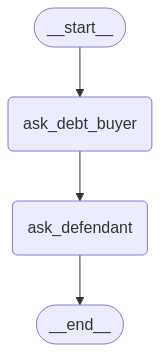

In [55]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,  
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(
                first="#ffdfba",
                last="#baffc9",
                default="#d0e1f9"
            ),
            wrap_label_n_words=5,
            background_color="white",
            padding=10,
        )
    )
)
